In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [29]:
import pandas as pd
import numpy as np
import nltk
from ipywidgets import Output
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import LdaModel
from gensim.models import Phrases
from itertools import chain
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from itertools import chain

In [2]:
from transformers import BertweetTokenizer

In [3]:
%matplotlib inline

In [32]:
train = pd.read_csv('../data/external/kaggle/train.csv')
test = pd.read_csv('../data/external/kaggle/test.csv')
y = pd.read_csv('../data/external/kaggle/train.csv')['target'].values
bertweet_tokenizer = BertweetTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)
vanilla_tokenizer = RegexpTokenizer(r'\w+')


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as SKLEARN_STOPWORDS
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOPWORDS
from nltk.corpus import stopwords

SKLEARN_STOPWORDS = set(SKLEARN_STOPWORDS)
out = Output()
with out:
    nltk.download('stopwords')
NLTK_STOPWORDS = set(stopwords.words('english'))
print(f'Loaded {len(NLTK_STOPWORDS)} stopwords from NLTK')
print(f'Loaded {len(SPACY_STOPWORDS)} stopwords from SPACY')
print(f'Loaded {len(SKLEARN_STOPWORDS)} stopwords from SKLEARN')
stop_words = list(set.union(*[SKLEARN_STOPWORDS, SPACY_STOPWORDS, NLTK_STOPWORDS]))
print('----------------------------------')
print(f'{len(stop_words)} combined stopwords')

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Loaded 179 stopwords from NLTK
Loaded 326 stopwords from SPACY
Loaded 318 stopwords from SKLEARN
----------------------------------
409 combined stopwords


In [92]:
def preview_corpus(corpus, num_items_to_display=5):
    for i,doc in enumerate(corpus[:num_items_to_display],1):
        print(f'Item {i}: {doc}')
        print()
        
def num_tokens_in_corpus(corpus):
    return len(list(chain(*corpus)))
        
def display_corr(df, s=10):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(s,s))
    ax = sns.heatmap(corr.round(3),mask=mask, annot=True, cbar=False, linewidths=0.3, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize='x-large');
    return fig, ax

In [145]:
#HYPERPARAMTERS
min_count_b = 5
min_count_t = 5
min_count_f = 5
##########################
tokenizer = bertweet_tokenizer
ADDITIONAL_STOP_WORDS = [] #ADD ADDITIONAL STOP WORDS HERE
stop_words.extend(ADDITIONAL_STOP_WORDS)
##########################
no_below = 100
no_above = 0.6
n_most_frequent = 0
##########################
num_topics = 100
chunksize = len(corpus)
passes = 100
iterations = 400
eval_every = None

In [44]:
print(vanilla_tokenizer.tokenize('https://test.com'))
print(bertweet_tokenizer.tokenize('https://test.com'))

['https', 'test', 'com']
['HTTPURL']


In [146]:
corpus = train['text'].values

In [147]:
%%time
####################################################################################################
#                                           PREPROCESSING                                          #
####################################################################################################
corpus = [doc.lower() for doc in corpus]
corpus = [tokenizer.tokenize(doc) for doc in corpus]
corpus = [[token for token in doc if (not token.isnumeric() and len(token) > 1)] for doc in corpus]
preview_corpus(corpus)
print(num_tokens_in_corpus(corpus))
print('*********************************************************************************************')
print('*********************************************************************************************')
####################################################################################################
bigram = Phrases(corpus, min_count=min_count_b)
trigram = Phrases(bigram[corpus], min_count=min_count_t)
fourgram = Phrases(trigram[corpus], min_count=min_count_f)
for doc in corpus:
    bigrams = [b for b in bigram[doc] if b.count('_') == 1]
    trigrams = [t for t in trigram[bigram[doc]] if t.count('_') == 2]
    fourgrams = [f for f in fourgram[trigram[bigram[doc]]] if f.count('_') == 3]
    doc.extend(list(chain(*[bigrams, trigrams, fourgrams])))
corpus = [[token for token in doc if (not token in stop_words)] for doc in corpus]
preview_corpus(corpus)
print(num_tokens_in_corpus(corpus))
print('*********************************************************************************************')
print('*********************************************************************************************')
####################################################################################################
dictionary = Dictionary(corpus)
# dictionary.filter_extremes(no_below=no_below, no_above=no_above)
# dictionary.filter_n_most_frequent(n_most_frequent)
corpus = [dictionary.doc2bow(doc) for doc in corpus]
preview_corpus(corpus)
print(num_tokens_in_corpus(corpus))
print('*********************************************************************************************')
print('*********************************************************************************************')
####################################################################################################
print(f'Corpus: {len(corpus)} Tweets')
print(f'Dictionary: {len(dictionary)} Tokens')

Item 1: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#earthquake', 'may', 'allah', 'forgive', 'us', 'all']

Item 2: ['forest', 'fire', 'near', 'la', 'ron@@', 'ge', 's@@', 'ask', 'canada']

Item 3: ['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']

Item 4: ['13@@', ',000', 'people', 'receive', '#wild@@', 'fires', 'evacuation', 'orders', 'in', 'california']

Item 5: ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', '#al@@', 'aska', 'as', 'smoke', 'from', '#wild@@', 'fires', 'pours', 'into', 'school']

126557
*********************************************************************************************
*********************************************************************************************
Item 1: ['deeds', 'reason', '#earthquake', 'allah', 'forgive']

Item 2: ['forest', 'near', 'la', 'ron@@', 'ge', 's@@', 'ask', 'canada'

In [148]:
%%time

temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

CPU times: user 3min 14s, sys: 379 ms, total: 3min 14s
Wall time: 3min 14s


In [149]:
%%time
topics = [model.get_document_topics(doc) for doc in corpus]
topics = [dict(topic_dist) for topic_dist in topics]
topics = pd.DataFrame(topics).fillna(0)
topics['label'] = y
topics

CPU times: user 3.81 s, sys: 7.96 ms, total: 3.82 s
Wall time: 3.81 s


,5,35,44,70,36,42,93,18,75,23,...,56,74,51,69,15,88,83,9,94,label
0,0.171396,0.171425,0.341572,0.171588,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.000000,0.000000,0.000000,0.487647,0.104274,0.321508,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337346,0.58971,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506787,0.304436,0.00000,0.102160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.169116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7610,0.000000,0.000000,0.000000,0.937041,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [81]:
#TO INVESTIGATE: THE LESS TOKENS, THE MORE CORRELATION (ENTRIES ZEROED OUT)
# THE MORE TOPICS, THE LESS CORRELATIONS (ENTRIES ZEROED OUT)

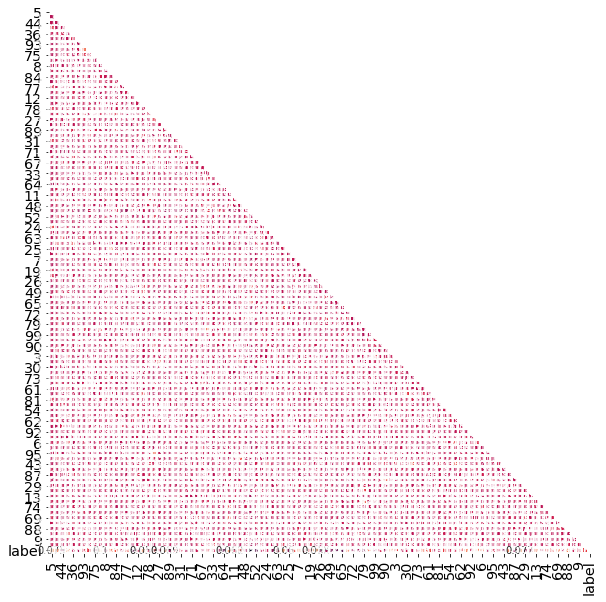

In [150]:
_,_ = display_corr(topics, 10)

In [151]:
t = [l for i,l in model.show_topics(formatted=False, num_words=100)]
t = [list(zip(*l))[0] for l in t]
preview_corpus(t, 8)

Item 1: ('ja@@', 'ja@@_made', 'nai@@', '...', 'best@@', 'best@@_nai@@', 'best@@_nai@@_ja@@_made', 'HTTPURL', '..._HTTPURL', 'û@@', 'desires', '16@@_yr_old_p@@', 'deton@@_ated_bomb', 'kk_suicide_bomber_who', 'ated', 'deton@@', 'deton@@_ated', 'bomb', 'be_careful', 'careful', 'control', 'bomber', '16@@_yr', 'p@@', '16@@', 'kk', 'suicide', 'yr', 'kk_suicide', 'bomber_who', 'old_p@@', 'old', '#best@@_nai@@_ja@@_made', '#best@@', '#best@@_nai@@', 'in_turkey_army_trench', 'surrounded', 'hell@@_fire', 'hell@@', 'let', 'ª@@', 'ª@@_let', 'afterlife', 'don_û@@', 'thursday', 'john', 'collapsed', 'xd', 'die', 'out_here', 'heal', 'new', 'lu@@', 'char@@', 'sinking', 'el', 'type', 'ready', 'ga@@', 'america', 'le@@', 'l@@', 'head', 'increase', 'b@@', 'hours', 'lungs', 'tr@@', 'ancy', 'alo@@', '2.5', 'attempt', 'troit', '25@@', 'ing@@', '#break@@', 'clinton', 'destroying', 'itters', 'nox@@', 'son', 'quarter', 'seattle', 'hmm', 'got', 'use', 'best', 'rt', 'ke@@', 'group', 'lightning', 'de@@', 'hostage',

In [152]:
%%time
corpus_in_topics_space, _ =model.inference(corpus)

CPU times: user 1.39 s, sys: 15 µs, total: 1.39 s
Wall time: 1.39 s


In [153]:
corpus_in_topics_space

array([[0.00805881, 0.00865778, 0.02176886, ..., 0.00836803, 0.0086932 ,
        0.00935042],
       [0.00805881, 0.00865778, 0.02176886, ..., 0.00836803, 0.0086932 ,
        0.00935042],
       [0.00805881, 0.00865778, 0.02176886, ..., 0.00836803, 0.0086932 ,
        0.00935042],
       ...,
       [0.00805881, 0.00865778, 0.02176886, ..., 0.00836803, 0.0086932 ,
        0.00935042],
       [0.00805881, 0.00865778, 0.02176886, ..., 0.00836803, 0.0086932 ,
        0.00935042],
       [0.00805881, 0.00865778, 0.02176886, ..., 0.00836803, 0.0086932 ,
        0.00935042]], dtype=float32)

In [122]:
model.inference?